# Stock price prediction

### Comparison of SARIMA model and LSTM Neural Network

### Importing library

In [136]:
import numpy as np
import pandas as pd
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from tqdm import tqdm_notebook

from itertools import product
warnings.filterwarnings('ignore')

### Importing data

In [137]:
df = pd.read_excel('CBA.AX5y.xls')

In [138]:
df.columns = df.columns.str.lower()

In [139]:
df = df.drop(labels = ['open', 'high', 'low', 'adj close', 'volume'], axis=1)

In [140]:
df['date']

0      2017-09-21
1      2017-09-22
2      2017-09-25
3      2017-09-26
4      2017-09-27
          ...    
1262   2022-09-15
1263   2022-09-16
1264   2022-09-19
1265   2022-09-20
1266   2022-09-21
Name: date, Length: 1267, dtype: datetime64[ns]

In [141]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2017-09-21')
datetime_object

datetime.datetime(2017, 9, 21, 0, 0)

In [142]:
 df.index = df.pop('date')

In [143]:
df

,close
date,
2017-09-21,76.070000
2017-09-22,76.620003
2017-09-25,75.809998
2017-09-26,75.099998
2017-09-27,74.849998
...,...
2022-09-15,95.059998
2022-09-16,94.230003
2022-09-19,94.660004


### Visualising data

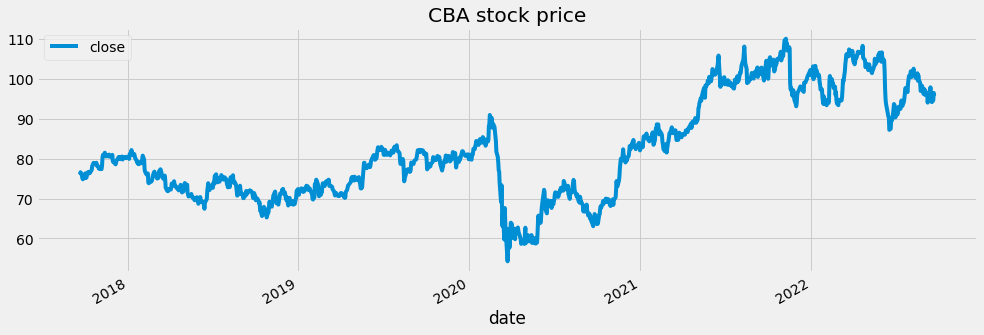

In [144]:
df.plot(style='-',
        figsize=(15, 5),
        title='CBA stock price')
plt.savefig('CBA stock price')
plt.show()

## Time Series analysis with SARIMA model

### Check for Stationarity

In [145]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        


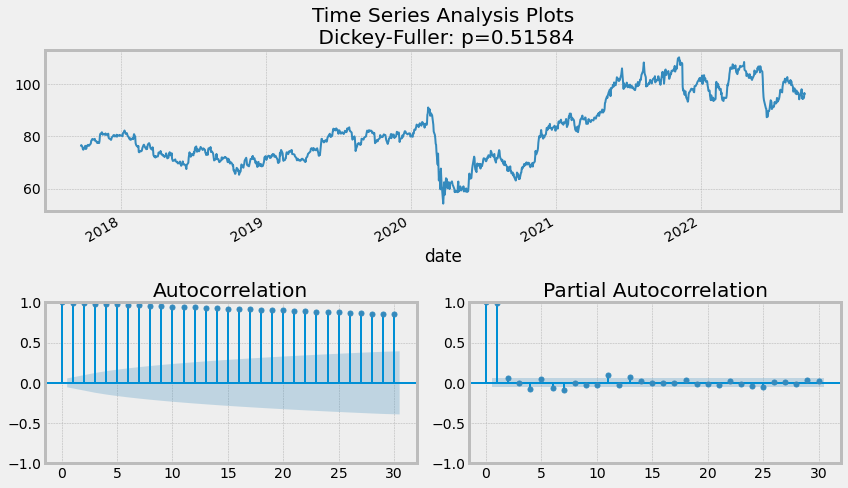

In [146]:
tsplot(df.close, lags=30)
plt.savefig('DFtest')
plt.show()

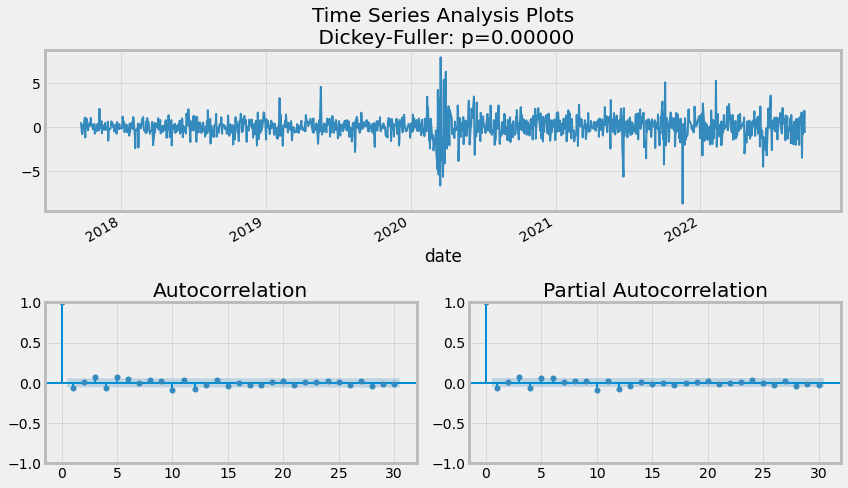

In [147]:
# Take the first difference to remove to make the process stationary
data_diff = df.close - df.close.shift(1)

tsplot(data_diff[1:], lags=30)
plt.savefig('DFconverted')
plt.show()

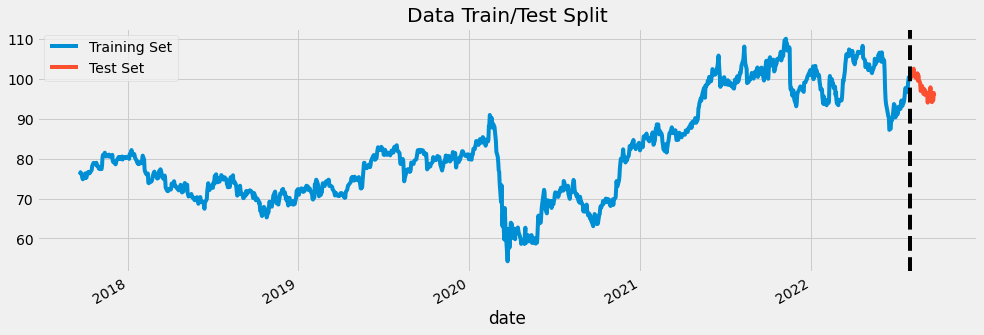

In [148]:
train = df.loc[df.index < '2022-08-01']
test = df.loc[df.index >= '2022-08-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-08-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.savefig('SarimaxTTsplit')
plt.show()

In [149]:
print(len(train))
print(len(test))

1229
38


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69288D+00    |proj g|=  2.36891D-01

At iterate    5    f=  1.61781D+00    |proj g|=  3.98577D-02

At iterate   10    f=  1.58489D+00    |proj g|=  2.29035D-02

At iterate   15    f=  1.58096D+00    |proj g|=  4.01557D-03

At iterate   20    f=  1.58069D+00    |proj g|=  7.36777D-03

At iterate   25    f=  1.57989D+00    |proj g|=  8.65814D-03

At iterate   30    f=  1.57986D+00    |proj g|=  6.07266D-04

At iterate   35    f=  1.57983D+00    |proj g|=  2.43314D-03

At iterate   40    f=  1.57927D+00    |proj g|=  1.34706D-02

At iterate   45    f=  1.57890D+00    |proj g|=  8.16006D-03

At iterate   50    f=  1.57882D+00    |proj g|=  2.01459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

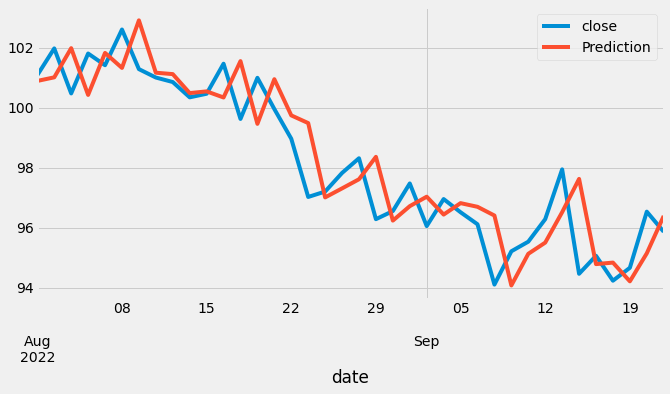

In [150]:
model = sm.tsa.statespace.SARIMAX(df['close'], order=(4,1,4), seasonal_order=(2,1,1,5))
res = model.fit()
start = len(train)
end = len(train) + len(test) - 1 #index number starts from zero
prediction = res.predict(start, end).rename('Prediction')
ax = test['close'].plot(legend=True, figsize = (10,5))
prediction.plot(legend=True)
plt.savefig('SarimaxPrediction')
plt.show()

In [152]:
mse = np.square(np.subtract(test['close'],prediction)).mean()   
rsme = math.sqrt(mse)  
print("Root Mean Square Error:\n")  
print(rsme)  

Root Mean Square Error:

1.1962196987797618


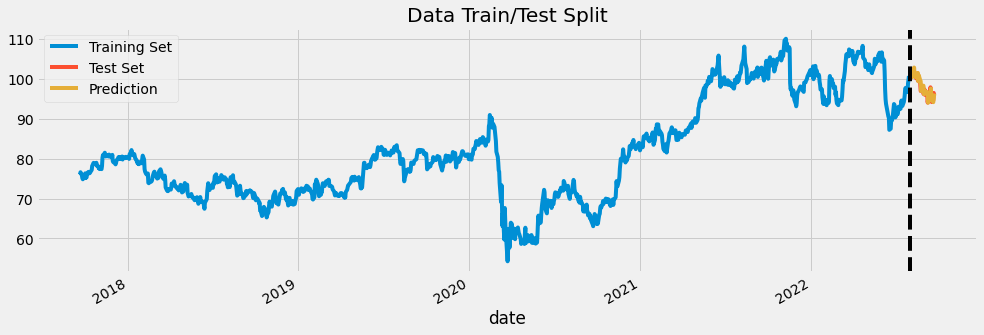

In [155]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
prediction.plot(ax=ax, label='Prediction')
ax.axvline('2022-08-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set', 'Prediction'])
plt.savefig('SarimaxTTPredict')
plt.show()

### LSTM Neural Network

In [165]:
train.head()

,close
date,
2017-09-21,76.070000
2017-09-22,76.620003
2017-09-25,75.809998
2017-09-26,75.099998
2017-09-27,74.849998


In [166]:
test.head()

,close,predictions_wf
date,,
2022-08-01,101.080002,date 2022-08-01 100.886348 2022-08-02 10...
2022-08-02,101.970001,date 2022-08-01 100.886348 2022-08-02 10...
2022-08-03,100.470001,date 2022-08-01 100.886348 2022-08-02 10...
2022-08-04,101.800003,date 2022-08-01 100.886348 2022-08-02 10...
2022-08-05,101.410004,date 2022-08-01 100.886348 2022-08-02 10...


In [164]:
train

,close,predictions_wf
date,,
2017-09-21,NaN,NaN
2017-09-22,NaN,NaN
2017-09-25,NaN,NaN
2017-09-26,NaN,NaN
2017-09-27,NaN,NaN
...,...,...
2022-09-15,NaN,NaN
2022-09-16,NaN,NaN
2022-09-19,NaN,NaN


In [ ]:
train = df.loc[df.index < '2022-08-01']
test = df.loc[df.index >= '2022-08-01']

In [ ]:
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [75]:
prediction.head()

1229    100.886348
1230    101.006354
1231    101.977953
1232    100.420378
1233    101.820053
Name: predicted_mean, dtype: float64